# Text Classification w. Basic Models

> *Text Analytics*  
> *MSc in Data Science, Department of Informatics*  
> *Athens University of Economics and Business*

---

<p style='text-align: justify;'>Develop a sentiment classifier for a kind of texts of your choice (e.g., tweets, product or movie reviews). Use an existing sentiment analysis dataset with at least two classes (e.g., positive/negative or positive/negative/neutral). The classes should be mutually exclusive, i.e., this is a single-label multi-class classification problem.</p>
    
<p style='text-align: justify;'>You should experiment with at least logistic regression (or multinomial logistic regression, if you have more than two classes) and optionally (if you are keen) additional learning algorithm (e.g., Naive Bayes, $k$-NN). Assume that each text is classified in the class the classifier considers most probable. Make sure that you use train, validation and test subsets. Tune the feature set and hyper-parameters (e.g., regularization weight $\lambda$ in logistic regression) on the validation subset. Include experimental results of a baseline majority classifier, i.e., a classifier that always assigns the most frequent class of the training data. For each classifier:</p>

<ul>
    <li>Calculate (macro-averaged) precision, recall, F1 both for the training and test subsets</li>
    <li>Calculate and plot the confusion matrices both for the training and test subsets</li>
    <li>Calculate and plot the precision-recall AUC scores both for the training and test subsets</li>
    <li>Calculate and plot the learning curves for the training subset</li>
</ul>

## *Table of Contents*

- [*1. Libraries*](#libraries)
- [*2. Data*](#data)
- [*3. Descriptive Statistics*](#descriptive_statistics)
- [*4. Data Cleansing*](#data_cleansing)
- [*5. Train Validation Test Split*](#train_valid_test_split)
- [*6. Text Vectorization*](#text_vectorization)
- [*7. Dimensionality Reduction*](#dimensionality_reduction)
- [*8. Hyperparameter Tuning*](#tuning)
- [*9. Classification Results*](#results)

---

## Libraries <a class='anchor' id='libraries'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import unidecode
import contractions
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

from sklearn.model_selection import cross_validate, StratifiedKFold, RandomizedSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, auc, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import learning_curve

import warnings
warnings.filterwarnings('ignore')

## Data <a class='anchor' id='data'></a>

- The data were acquired from [kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews) and is the ["Large Movie Review Dataset"](https://ai.stanford.edu/~amaas/data/sentiment/) by Andrew Maas
- This is a dataset for binary sentiment classification which contains 50K movie reviews
- The reviews are labelled either as positive or negative
- The two classes are balanced with each containing 25K reviews

> *@InProceedings{maas-EtAl:2011:ACL-HLT2011,*  
>   *author    = {Maas, Andrew L.  and  Daly, Raymond E.  and  Pham, Peter T.  and  Huang, Dan  and  Ng, Andrew Y.  and  Potts, Christopher},*  
>   *title     = {Learning Word Vectors for Sentiment Analysis},*  
>   *booktitle = {Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies},*  
>   *month     = {June},*  
>   *year      = {2011},*  
>   *address   = {Portland, Oregon, USA},*  
>   *publisher = {Association for Computational Linguistics},*  
>   *pages     = {142--150},*  
>   *url       = {http://www.aclweb.org/anthology/P11-1015}*  
> }

##### *Read the data*

In [2]:
# read the dataset
raw = pd.read_csv('./data/IMDB Dataset.csv')

# shape
print(f'raw.shape: {raw.shape}', end='\n\n')

# preview
print(raw.head())

raw.shape: (50000, 2)

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


##### *Convert target column `sentiment` from string to binary*

In [3]:
# create a copy of raw data to work with
df = raw.copy()

# convert target column from string to binary
df.sentiment = df.sentiment.apply(lambda x: 0 if x == 'negative' else 1)

# count positive vs negative reviews
print(f'There are {len(df[df.sentiment == 0])} negative and {len(df[df.sentiment == 1])} positive reviews.', end='\n\n')

# preview the first 5 reviews
for i in range(5):
    print(f'{i+1} - {df.review[i]}', end='\n\n')

There are 25000 negative and 25000 positive reviews.

1 - One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br /

## Descriptive Statistics <a class='anchor' id='descriptive_statistics'></a>

- In this step we will do a brief analysis to extract some basic descriptive statistics about the reviews
- Specifically, we will calculate the vocabulary size and the avg/min/max review length for each class

##### *Define function to obtain some descriptive statistics*

Vocabulary

There are 438729 unique words.
Reviews Statistics

Positive Reviews
- Average Length: 1324
- Minimum Length: 65
- Maximum Length: 13704

Negative Reviews
- Average Length: 1294
- Minimum Length: 32
- Maximum Length: 8969



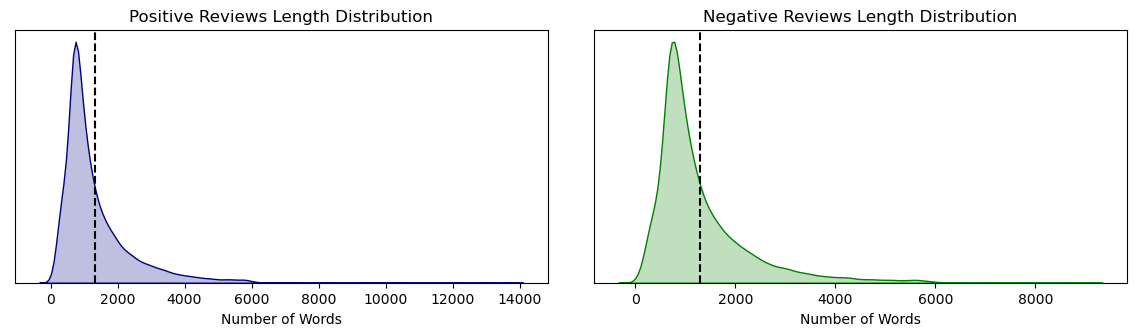

In [4]:
def descriptive_statistics(df):
    
    # get the vocabulary size
    # aka number of unique words appeared in the reviews
    vocabulary_size = len(list(set(' '.join(df.review).split())))
    
    # get the length of each review
    df['review_length'] = df.review.apply(lambda x: len(x))
    
    # get the avg, min, max review length (overall)
    avg_len = int(np.mean(df.review_length))
    min_len = df.review_length.min()
    max_len = df.review_length.max()
    
    # get the avg, min, max review length (positive class)
    avg_len_pos = int(np.mean(df[df.sentiment == 1].review_length))
    min_len_pos = df[df.sentiment == 1].review_length.min()
    max_len_pos = df[df.sentiment == 1].review_length.max()
    
    # get the avg, min, max review length (negative class)
    avg_len_neg = int(np.mean(df[df.sentiment == 0].review_length))
    min_len_neg = df[df.sentiment == 0].review_length.min()
    max_len_neg = df[df.sentiment == 0].review_length.max()
    
    print('='*117)
    print('Vocabulary', end='\n\n')
    print(f'There are {vocabulary_size} unique words.')
    print('='*117)
    print('Reviews Statistics', end='\n\n')    
    print(f'Positive Reviews')
    print(f'- Average Length: {avg_len_pos}')
    print(f'- Minimum Length: {min_len_pos}')
    print(f'- Maximum Length: {max_len_pos}', end='\n\n')
    print(f'Negative Reviews')
    print(f'- Average Length: {avg_len_neg}')
    print(f'- Minimum Length: {min_len_neg}')
    print(f'- Maximum Length: {max_len_neg}', end='\n\n')
    print('='*117)
    
    # create figure
    fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4),dpi=100,facecolor='white')
    # plot positive reviews length distribution
    sns.kdeplot(x=df[df.sentiment == 1].review_length, shade=True, color='navy', ax=ax1)
    ax1.axvline(avg_len_pos, linestyle='--', color='black')
    ax1.set_xlabel('Number of Words')
    ax1.set_ylabel(None)
    ax1.set_yticks([])
    ax1.set_title('Positive Reviews Length Distribution')
    # plot negative reviews length distribution
    sns.kdeplot(x=df[df.sentiment == 0].review_length, shade=True, color='green', ax=ax2)
    ax2.axvline(avg_len_neg, linestyle='--', color='black')
    ax2.set_xlabel('Number of Words')
    ax2.set_ylabel(None)
    ax2.set_yticks([])
    ax2.set_title('Negative Reviews Length Distribution')
    plt.tight_layout(pad=3)
    plt.savefig(f'./images/reviews_length_distribution.svg')
    plt.show()
    
    return

# execute function
_ = descriptive_statistics(df)

## Data Cleansing <a class='anchor' id='data_cleansing'></a>

- Before we proceed with the next steps, we first need to clean our data
- Therefore, we will apply the following preprocessing steps to the reviews:
    - Convert to lowercase
    - Replace accented characters
    - Expand contractions
    - Remove HTML tags
    - Replace non alphabet characters with space
    - Remove stopwords
    - Remove words with less than 4 characters
    - Perform stemming
    
##### *Define function to clean and preprocess the reviews*

In [5]:
def preprocess_data(review):

    # convert to lowercase
    review = review.strip().lower()

    # replace accented characters
    review = unidecode.unidecode(review)

    # expand contractions
    review = contractions.fix(review)

    # remove html tags
    review = re.sub(r'<.*?>', ' ', review)

    # replace non alphabet characters with space
    review = re.sub(r'[^a-z]', ' ', review)

    # split into words
    review = review.split()

    # remove stopwords
    review = [word for word in review if word not in stopwords.words('english')]

    # remove words with less than 3 chars
    review = [word for word in review if len(word) > 3]

    # stemming
    stemmer = PorterStemmer()
    review = [stemmer.stem(word) for word in review]

    # join the word to form the sentence
    review = ' '.join(review)

    return review

# starting time
start_time = datetime.now()

# execute function
df.review = df.review.apply(preprocess_data)

# end time
end_time = datetime.now()

print(f'Elapsed time: {end_time - start_time}', end='\n\n')

# preview the first 5 reviews
for i in range(5):
    print(f'{i+1} - {df.review[i]}', end='\n\n')

Elapsed time: 0:15:15.192305

1 - review mention watch episod hook right exactli happen first thing struck brutal unflinch scene violenc right word trust show faint heart timid show pull punch regard drug violenc hardcor classic word call nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda citi home mani aryan muslim gangsta latino christian italian irish scuffl death stare dodgi deal shadi agreement never away would main appeal show fact goe show would dare forget pretti pictur paint mainstream audienc forget charm forget romanc mess around first episod ever struck nasti surreal could readi watch develop tast accustom high level graphic violenc violenc injustic crook guard sold nickel inmat kill order away well manner middl class inmat turn prison bitch lack street skill prison experi watch becom comfort uncomfort view touch darker side

2 - wonder littl product film techniqu unassum 

## Train Validation Test Split <a class='anchor' id='train_valid_test_split'></a>

- Next, we will split the data into *training* set $(70\%)$, *validation* set $(15\%)$ and *test* set $(15\%)$
- We, also, use stratified split to keep the same distribution of positive and negative reviews between the three subsets

##### *Define a function to split the data into three subsets*

In [6]:
def train_validation_test_split_reviews(dataset):

    # define x and y
    x = dataset.review
    y = dataset.sentiment

    # split into train - validation + test sets
    x_train, x_valid_test, y_train, y_valid_test = train_test_split(x,
                                                                    y,
                                                                    test_size=0.3,
                                                                    shuffle=True,
                                                                    stratify=y,
                                                                    random_state=1)
    
    # split into validation - test sets
    x_valid, x_test, y_valid, y_test = train_test_split(x_valid_test,
                                                        y_valid_test,
                                                        test_size=0.5,
                                                        shuffle=True,
                                                        stratify=y_valid_test,
                                                        random_state=1)
    
    
    # preview the sizes
    print(f'len(reviews):   {len(dataset)}')
    print(f'len(train_set): {len(x_train)}')
    print(f'len(valid_set): {len(x_valid)}')
    print(f'len(test_set):  {len(x_test)}')

    return x_train, x_valid, x_test, y_train, y_valid, y_test

# execute function
x_train, x_valid, x_test, y_train, y_valid, y_test = train_validation_test_split_reviews(df)

len(reviews):   50000
len(train_set): 35000
len(valid_set): 7500
len(test_set):  7500


## Text Vectorization <a class='anchor' id='text_vectorization'></a>

- The next step is to vectorize the reviews into term-document matrices using TF-IDF
- TF-IDF is a measure that quantifies the importance or relevance of string representations in a document amongst a collection of documents (aka corpus)
- In our case, we will extract the vectors for both unigrams and bigrams and consider only the top $10000$ features
- Finally, we will apply sublinear tf scaling, i.e. replace tf with $1 + log(tf)$ (converting tf-idf to wf-idf)

##### *Define a function to perform text vectorization*

In [7]:
def text_vectorization(x_train, x_valid, x_test):

    # initialize the TFIDF vectorizer
    vectorizer = TfidfVectorizer(ngram_range=(1,2), max_features=10000, sublinear_tf=True)
    
    # vectorize the reviews in train and test sets
    x_train_tfidf = vectorizer.fit_transform(x_train)
    x_valid_tfidf = vectorizer.transform(x_valid)
    x_test_tfidf = vectorizer.transform(x_test)

    return x_train_tfidf, x_valid_tfidf, x_test_tfidf

# execute function
x_train_tfidf, x_valid_tfidf, x_test_tfidf = text_vectorization(x_train, x_valid, x_test)

## Dimensionality Reduction <a class='anchor' id='dimensionality_reduction'></a>

- In addition, we will perform dimensionality reduction on the vectors generated from the previous step to reduce the number of features
- In particular, we will use the Truncated SVD transformer which performs linear dimensionality reduction and works well with sparse matrices
- Due to time and resource limitations, we will reduce the dimensionality to $2000$ features
- This results in an explained variance ratio of $60\%$ of our initial feature vectors

##### *Define a function to perform dimensionality reduction*

In [8]:
def dimensionality_reduction(x_train_tfidf, x_valid_tfidf, x_test_tfidf):

    # initialize the truncated SVD transformer
    n_components = 2000
    svd = TruncatedSVD(n_components=n_components, random_state=1)

    # decompose the values
    # in training, validation and test sets
    x_train_svd = svd.fit_transform(x_train_tfidf)
    x_valid_svd = svd.transform(x_valid_tfidf)
    x_test_svd = svd.transform(x_test_tfidf)

    # print the explained variance ratio
    print(f'The explained variance ratio with {n_components} components is {svd.explained_variance_ratio_.sum():.3}.', end='\n\n')

    return x_train_svd, x_valid_svd, x_test_svd

# starting time
start_time = datetime.now()

# execute function
x_train_svd, x_valid_svd, x_test_svd = dimensionality_reduction(x_train_tfidf, x_valid_tfidf, x_test_tfidf)

# end time
end_time = datetime.now()

print(f'Elapsed time: {end_time - start_time}')

The explained variance ratio with 2000 components is 0.598.

Elapsed time: 0:02:19.014651


## Hyperparameter Tuning <a class='anchor' id='tuning'></a>

- For our predictions, apart from a baseline `DummyClassifier`, we will use the following models:
    - `SGDClassifier`
    - `LogisticRegression`
    - `KNeighborsClassifier`
    - `LGBMClassifier`
- However, before we train our models, we want to optimize the hyperparameters of our classifiers using the ***validation*** set
- Therefore, we will define a grid with several hyperparameters to be tested for each classifier
- We will use a `RandomizedSearchCV` function along with a $5$-fold stratified cross validation
- Finally, we will evaluate the scores obtained from cross validation using the F1-Score metric

##### *Define function to tune the models' hyperparameters*

In [9]:
def hyperparameter_tuning(x_valid_svd, y_valid):
    
    # list of classifiers
    models = [['SGDClassifier', SGDClassifier(random_state=1)],
              ['LogisticRegression', LogisticRegression(random_state=1)],
              ['LightGBM', LGBMClassifier(random_state=1)]]
    
    # list with hyperparameters to test
    param_grid = [['SGDClassifier', {'loss': ['hinge','loss','modified_huber'],
                                     'alpha': np.arange(0.01, 1, 0.01)}],
                  ['LogisticRegression', {'penalty': ['l1','l2'],
                                          'C': np.arange(0.01, 1, 0.01),
                                          'solver': ['lbfgs','sag','saga'],
                                          'max_iter': range(100,600,100)}],
                  ['LightGBM', {'n_estimators': range(100,400,100),
                                'max_depth': range(3,12,3)}]]
    
    # create a dataframe to store the results
    rs_scores = pd.DataFrame(np.nan, index=[model[0] for model in models], columns=['F1 Score'])

    # loop through classifiers
    for index, model in enumerate(models):
        
        # RandomizedSearchCV
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
        rs = RandomizedSearchCV(model[1], param_grid[index][1], scoring='f1', cv=cv, random_state=1, n_jobs=-1)
        rs.fit(x_valid_svd, y_valid)
        
        # evaluate
        best_score = rs.best_score_
        best_params = rs.best_params_
        best_estimator = rs.best_estimator_
        
        # print results
        print('='*117)
        print(f'{model[0]}')
        print('-'*117)
        print(f'Best grid score: {best_score}')
        print(f'Best grid params: {best_params}')
        print(f'Best estimator: {best_estimator}', end='\n\n')
        
        # store the results
        rs_scores.loc[model[0], 'F1 Score'] = best_score
    
    return rs_scores

# starting time
start_time = datetime.now()

# execute function
rs_scores = hyperparameter_tuning(x_valid_svd, y_valid)

# end time
end_time = datetime.now()

print(f'Elapsed time: {end_time - start_time}')

SGDClassifier
---------------------------------------------------------------------------------------------------------------------
Best grid score: 0.8408590093958102
Best grid params: {'loss': 'modified_huber', 'alpha': 0.91}
Best estimator: SGDClassifier(alpha=0.91, loss='modified_huber', random_state=1)

LogisticRegression
---------------------------------------------------------------------------------------------------------------------
Best grid score: 0.873103275159935
Best grid params: {'solver': 'lbfgs', 'penalty': 'l2', 'max_iter': 300, 'C': 0.97}
Best estimator: LogisticRegression(C=0.97, max_iter=300, random_state=1)

LightGBM
---------------------------------------------------------------------------------------------------------------------
Best grid score: 0.8458894350507931
Best grid params: {'n_estimators': 300, 'max_depth': 3}
Best estimator: LGBMClassifier(max_depth=3, n_estimators=300, random_state=1)

Elapsed time: 0:09:48.311903


##### *Concat training and validation subsets in a single set*

In [10]:
# concat training and validation subsets
# to use them both as a single set to train the models
x_train_concat = np.concatenate((x_train_svd, x_valid_svd))
y_train_concat = np.concatenate((y_train, y_valid))

# pass the values in a dictionary
sets = {'train': [x_train_concat, y_train_concat], 'test': [x_test_svd, y_test]}

## Classification Results <a class='anchor' id='results'></a>

### *Evaluation*

- We will use several metrics to compare performance between classifiers
- In particular, we will use *Precision*, *Recall* and *F1-Score*
- Furthermore, we will compute the macro-averaged values of the aforementioned metrics
- Finally, we will plot the *Confusion Matrices* and the *Precision-Recall AUC Curves*

##### *Define function to evaluate the performance between classifiers*

# 1 - DummyClassifier (train set)
------------------------------------------------------------
                     precision    recall  f1-score   support

Negative Review (0)       0.50      1.00      0.67     21250
Positive Review (1)       0.00      0.00      0.00     21250

           accuracy                           0.50     42500
          macro avg       0.25      0.50      0.33     42500
       weighted avg       0.25      0.50      0.33     42500

# 1 - DummyClassifier (test set)
------------------------------------------------------------
                     precision    recall  f1-score   support

Negative Review (0)       0.50      1.00      0.67      3750
Positive Review (1)       0.00      0.00      0.00      3750

           accuracy                           0.50      7500
          macro avg       0.25      0.50      0.33      7500
       weighted avg       0.25      0.50      0.33      7500



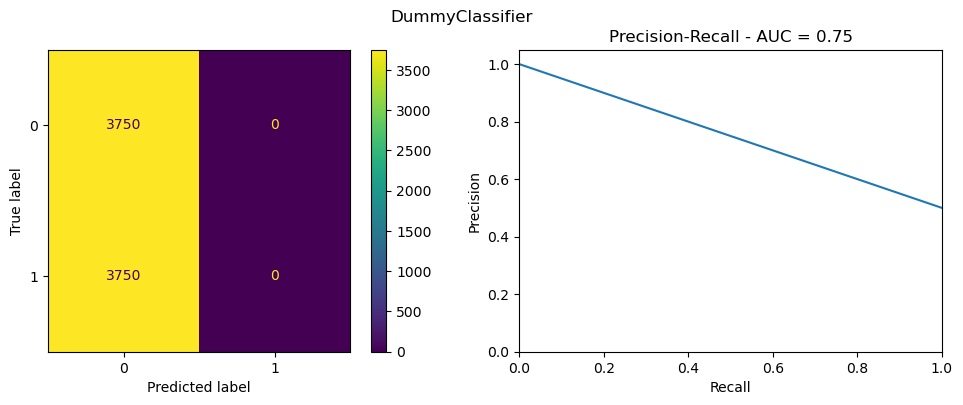

# 2 - GaussianNB (train set)
------------------------------------------------------------
                     precision    recall  f1-score   support

Negative Review (0)       0.68      0.67      0.67     21250
Positive Review (1)       0.67      0.68      0.68     21250

           accuracy                           0.67     42500
          macro avg       0.67      0.67      0.67     42500
       weighted avg       0.67      0.67      0.67     42500

# 2 - GaussianNB (test set)
------------------------------------------------------------
                     precision    recall  f1-score   support

Negative Review (0)       0.61      0.83      0.70      3750
Positive Review (1)       0.73      0.47      0.57      3750

           accuracy                           0.65      7500
          macro avg       0.67      0.65      0.64      7500
       weighted avg       0.67      0.65      0.64      7500



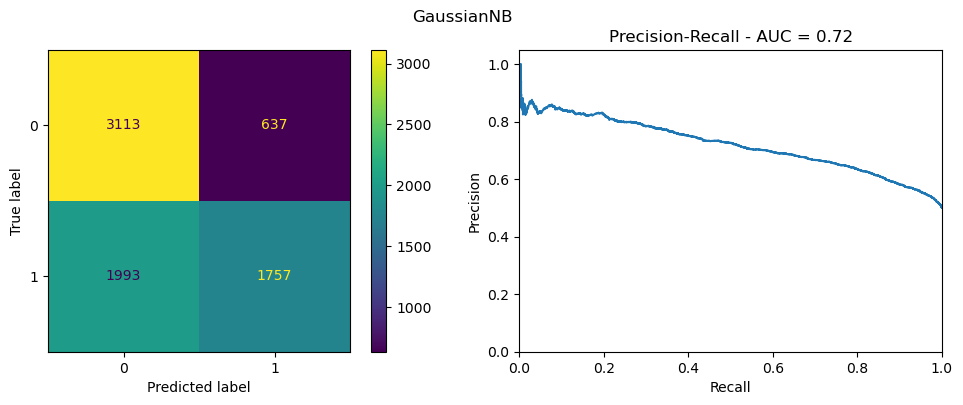

# 3 - SGDClassifier (train set)
------------------------------------------------------------
                     precision    recall  f1-score   support

Negative Review (0)       0.85      0.84      0.85     21250
Positive Review (1)       0.84      0.85      0.85     21250

           accuracy                           0.85     42500
          macro avg       0.85      0.85      0.85     42500
       weighted avg       0.85      0.85      0.85     42500

# 3 - SGDClassifier (test set)
------------------------------------------------------------
                     precision    recall  f1-score   support

Negative Review (0)       0.84      0.85      0.84      3750
Positive Review (1)       0.85      0.84      0.84      3750

           accuracy                           0.84      7500
          macro avg       0.84      0.84      0.84      7500
       weighted avg       0.84      0.84      0.84      7500



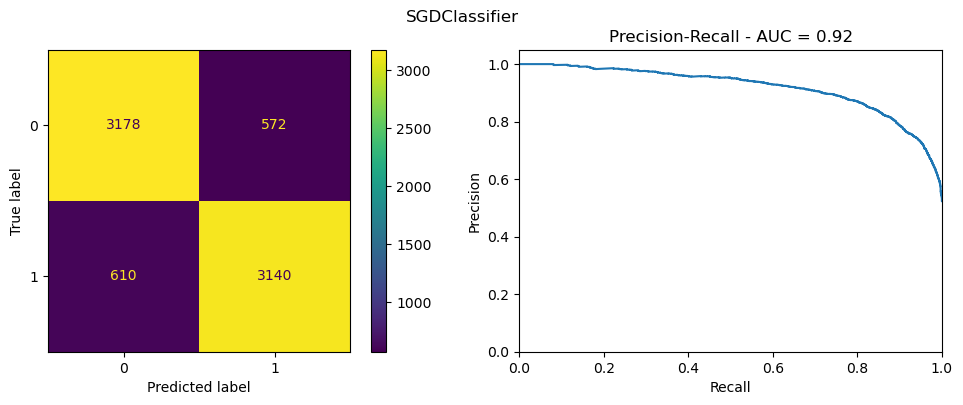

# 4 - LogisticRegression (train set)
------------------------------------------------------------
                     precision    recall  f1-score   support

Negative Review (0)       0.91      0.89      0.90     21250
Positive Review (1)       0.89      0.91      0.90     21250

           accuracy                           0.90     42500
          macro avg       0.90      0.90      0.90     42500
       weighted avg       0.90      0.90      0.90     42500

# 4 - LogisticRegression (test set)
------------------------------------------------------------
                     precision    recall  f1-score   support

Negative Review (0)       0.90      0.88      0.89      3750
Positive Review (1)       0.88      0.90      0.89      3750

           accuracy                           0.89      7500
          macro avg       0.89      0.89      0.89      7500
       weighted avg       0.89      0.89      0.89      7500



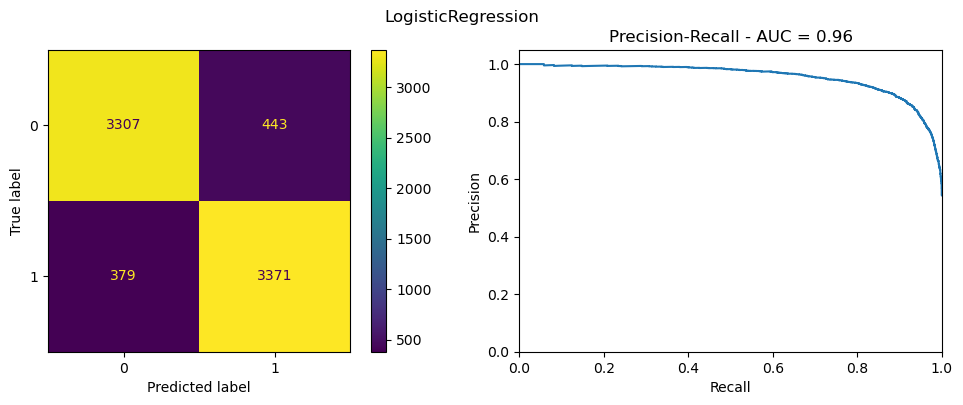

# 5 - LightGBM (train set)
------------------------------------------------------------
                     precision    recall  f1-score   support

Negative Review (0)       0.90      0.88      0.89     21250
Positive Review (1)       0.88      0.90      0.89     21250

           accuracy                           0.89     42500
          macro avg       0.89      0.89      0.89     42500
       weighted avg       0.89      0.89      0.89     42500

# 5 - LightGBM (test set)
------------------------------------------------------------
                     precision    recall  f1-score   support

Negative Review (0)       0.87      0.86      0.86      3750
Positive Review (1)       0.86      0.87      0.86      3750

           accuracy                           0.86      7500
          macro avg       0.86      0.86      0.86      7500
       weighted avg       0.86      0.86      0.86      7500



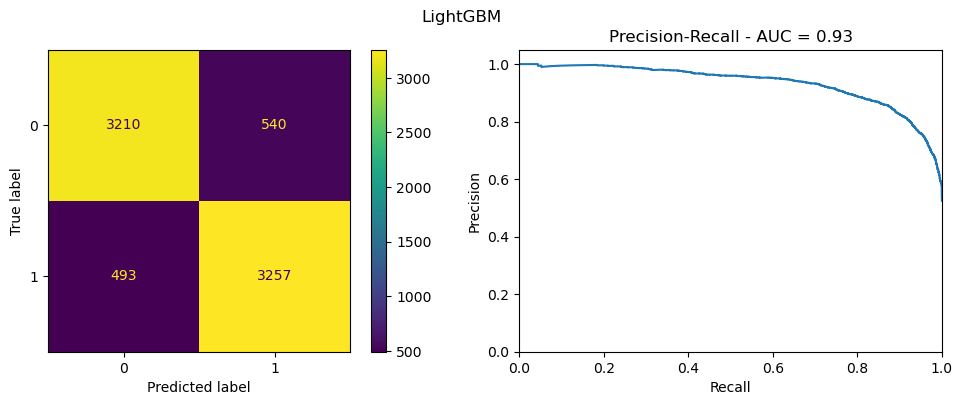

In [11]:
def calculate_metrics(sets):
    
    # list of classifiers
    models = [['DummyClassifier', DummyClassifier(strategy='most_frequent', random_state=1)],
              ['GaussianNB', GaussianNB()],
              ['SGDClassifier', SGDClassifier(alpha=0.91, loss='modified_huber', random_state=1)],
              ['LogisticRegression', LogisticRegression(C=0.97, max_iter=300, random_state=1)],
              ['LightGBM', LGBMClassifier(max_depth=3, n_estimators=300, random_state=1)]]

    # loop through classifiers
    for i, (name, model) in enumerate(models):
        
        print('='*117)

        # loop through train and test sets
        for j, (key, values) in enumerate(sets.items()):

            print(f'# {i+1} - {name} ({key} set)\n' + '-'*60)

            # fit the model in the train set
            if key == 'train':
                clf = model.fit(values[0], values[1])
            
            # predict
            preds = clf.predict(values[0])

            # classification report
            target_names = ['Negative Review (0)', 'Positive Review (1)']
            class_report = classification_report(values[1], preds, labels=np.unique(values[1]), target_names=target_names)
            print(class_report)

            # only for test set
            if j != 0:
                
                # create figure
                fig = plt.figure(figsize=(12,4),dpi=100,facecolor='white')

                # compute and plot the confusion matrix
                ax1 = fig.add_subplot(121)
                conf_matrix = ConfusionMatrixDisplay.from_estimator(clf, values[0], values[1], ax=ax1)

                # compute and plot the precision recall auc curve
                preds_proba = clf.predict_proba(values[0])
                precision, recall, thresholds = precision_recall_curve(values[1], preds_proba[:,1])
                area = auc(recall, precision)
                
                ax2 = fig.add_subplot(122)
                ax2.plot(recall, precision)
                ax2.set_xlabel('Recall')
                ax2.set_ylabel('Precision')
                ax2.set_ylim([0.0, 1.05])
                ax2.set_xlim([0.0, 1.0])
                ax2.set_title(f'Precision-Recall - AUC = {area:.2}')
                fig.suptitle(f'{name}')
                plt.savefig(f'./images/auc_curves_{name}.svg')
                plt.show()

    return

# execute function
_ = calculate_metrics(sets)

##### *Comment*

- It seems that the best performing classifier is `LogisticRegression`
- It yields slightly better results than `LightGBM` both in training and test sets
- Specifically, for the test set, it yields macro-averaged values for *Precision*, *Recall* and *F1-Score* equal to $0.89$, and an *AUC Score* of $0.96$

### *Learning Curves*

- The learning curves show the training and validation score of an estimator for varying numbers of training samples
- It is a tool to find out how much we benefit from adding more training data
- It can also show whether the estimator suffers more from a variance error or a bias error
- In general, it is good practice to plot them to identify potential overfitting or underfitting

##### *Define function to plot the learning curves for each classifier*

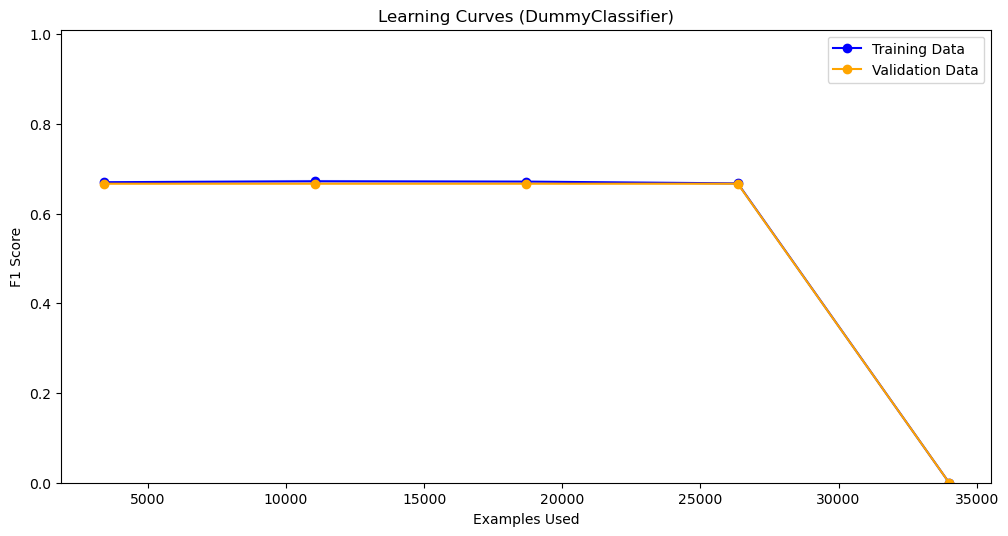

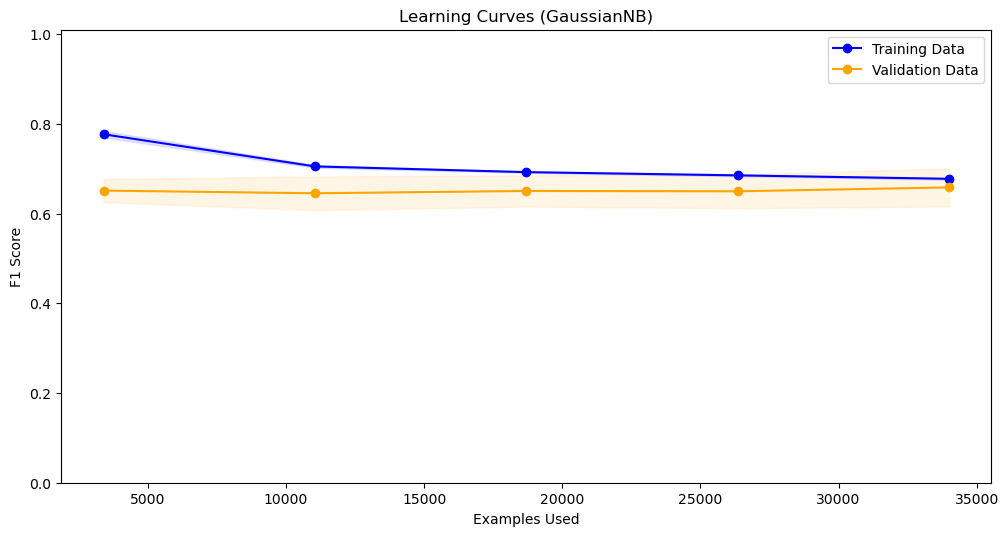

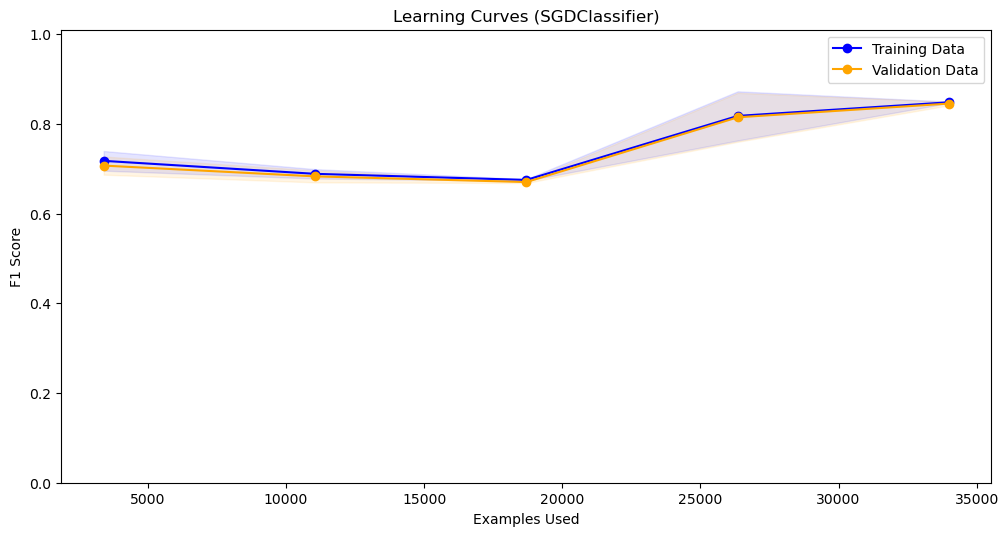

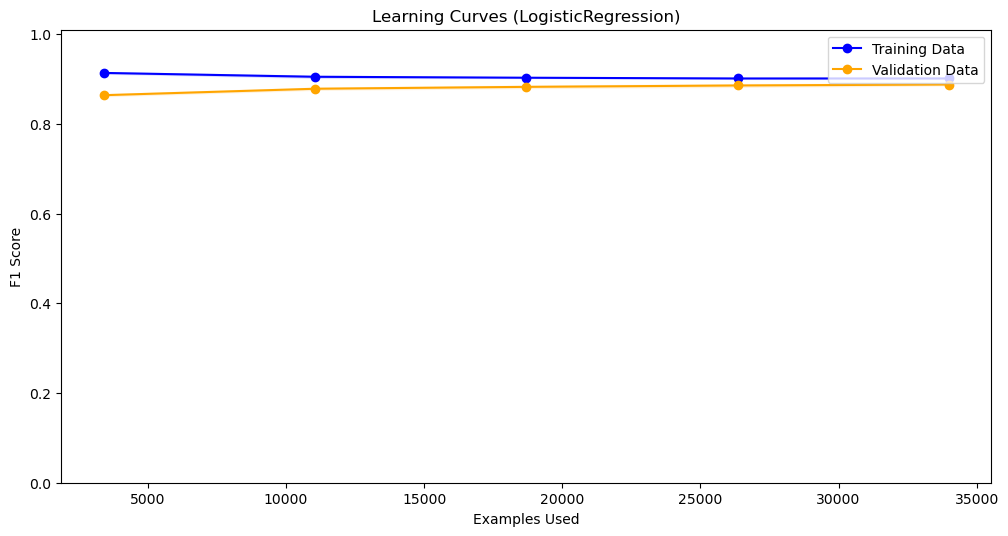

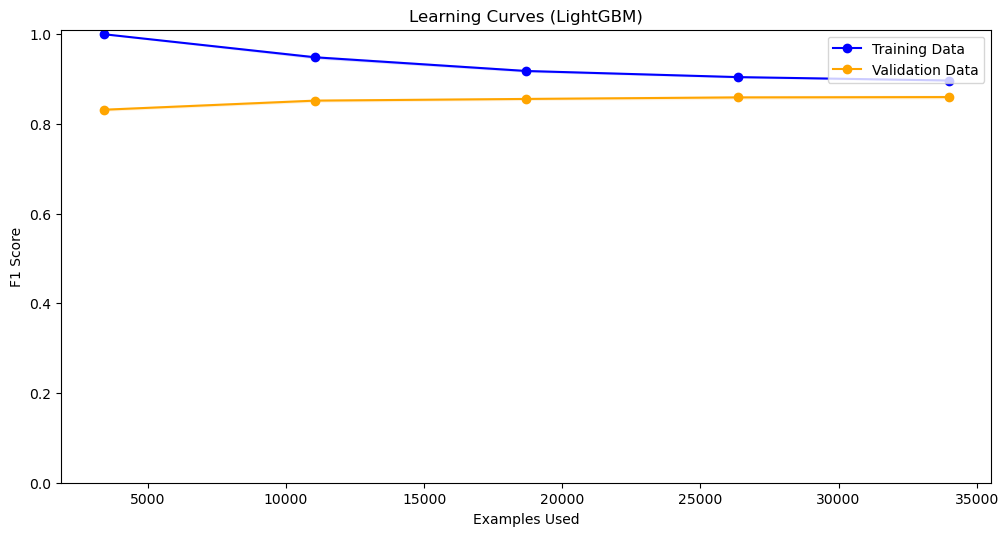

In [12]:
def plot_learning_curves(sets):

    # list of classifiers
    models = [['DummyClassifier', DummyClassifier(strategy='most_frequent', random_state=1)],
              ['GaussianNB', GaussianNB()],
              ['SGDClassifier', SGDClassifier(alpha=0.91, loss='modified_huber', random_state=1)],
              ['LogisticRegression', LogisticRegression(C=0.97, max_iter=300, random_state=1)],
              ['LightGBM', LGBMClassifier(max_depth=3, n_estimators=300, random_state=1)]]
    
    # loop through classifiers
    for i, (name, model) in enumerate(models):

        # train data
        x_train = sets['train'][0]
        y_train = sets['train'][1]
        train_sizes, train_scores, valid_scores = learning_curve(model,
                                                                 x_train,
                                                                 y_train,
                                                                 cv=5,
                                                                 train_sizes=np.linspace(.1, 1.0, 5),
                                                                 scoring='f1',
                                                                 random_state=1,
                                                                 n_jobs=-1)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        valid_scores_mean = np.mean(valid_scores, axis=1)
        valid_scores_std = np.std(valid_scores, axis=1)
        
        # create figure
        plt.figure(figsize=(12,6), dpi=100, facecolor='white')

        # plot std confidence intervals
        plt.fill_between(train_sizes,
                         train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std,
                         alpha=0.1,
                         color="blue")
        plt.fill_between(train_sizes,
                         valid_scores_mean - valid_scores_std,
                         valid_scores_mean + valid_scores_std,
                         alpha=0.1,
                         color="orange")

        # plot the curves
        plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training Data")
        plt.plot(train_sizes, valid_scores_mean, 'o-', color="orange", label="Validation Data")

        plt.xlabel("Examples Used")
        plt.ylabel("F1 Score")
        plt.ylim(0.0, 1.01)
        plt.title(f'Learning Curves ({name})')
        plt.legend(loc=1)
        plt.savefig(f'./images/learning_curve_{name}.svg')
        plt.show()

    return

# execute function
_ = plot_learning_curves(sets)

---

*Thank you!*

---